In [1]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import corner
import copy
import pickle
import math
import time
import matplotlib.gridspec as gridspec

from astropy.io import ascii
from itertools import cycle
from itertools import permutations
from scipy.stats import skew

%matplotlib inline

In [2]:
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['axes.facecolor']='white'
mpl.rcParams['axes.edgecolor']='k'
mpl.rcParams['axes.linewidth']=3
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['text.color'] = 'k'
#mpl.rcParams['xtick.major.width'] = 2
#mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['xtick.color']='k'
mpl.rcParams['ytick.color']='k'
mpl.rcParams['axes.labelcolor']='k'

mpl.rcParams['font.size']=12
mpl.rcParams['xtick.direction']='in'
mpl.rcParams['ytick.direction']='in'
mpl.rcParams['xtick.major.size'] = 5.5
mpl.rcParams['ytick.major.size'] = 5.5
mpl.rcParams['xtick.minor.size'] = 3.5
mpl.rcParams['ytick.minor.size'] = 3.5


def makeCmap(hexColour,zeroColour='#FFFFFF'):
    r0,g0,b0=mpl.colors.hex2color(zeroColour)
    r,g,b=mpl.colors.hex2color(hexColour)
    cdict = {'red':   ((0.0, r0, r0),
                   (1.0, r, r)),
         'green': ((0.0, g0, g0),
                   (1.0, g, g)),
         'blue':  ((0.0, b0, b0),
                   (1.0, b, b))
        }
    cmap = mpl.colors.LinearSegmentedColormap(hexColour,cdict)
    return cmap


def makeGradient(hexColour):
    r,g,b=mpl.colors.hex2color(hexColour)
    cdict = {'red':   ((0.0, r, r),
                   (1.0, r, r)),
         'green': ((0.0, g, g),
                   (1.0, g, g)),
         'blue':  ((0.0, b, b),
                   (1.0, b, b)),
         'alpha':  ((0.0, 0.0, 0.0),
                   (1.0, 1.0, 1.0))
        }
    cmap = mpl.colors.LinearSegmentedColormap(hexColour,cdict)
    return cmap


def makePlotColours(mappableList,coloursList):
    """
    mappableArray = a list of discrete values, each corresponding to a unique color (zero-indexed)
    coloursList = list of desired colors. Ideally should be at least as many colours as there are unique
                  entries in mappableArray.
    """

    nColours = np.max(mappableList)+1
    uniqueMappableList = np.arange(nColours)
    
    zidx = np.array((mappableList))

    cidx = 0
    colourMaps = []
    cycledColours = []
    for c in cycle(coloursList):
        colourMaps.append(makeGradient(c))
        cycledColours.append(c)
        cidx+=1
        if cidx >= nColours: 
            break
    
    blankCmap=makeGradient('#FFFFFF')
    colours = blankCmap(0.999*np.ones_like(zidx))

    for j in range(0,nColours):
        colours[zidx==j] = colourMaps[j](0.999*np.ones_like(np.arange(0,len(zidx))[zidx==j]))

    return colourMaps,colours,cycledColours,list(uniqueMappableList)

In [3]:
def getLossFromLogfile(filename):
    with open(filename) as f:
        content = f.readlines()
    f.close()
    lastEpoch = content[-5].split("|")
    lastEpochCost = float(lastEpoch[2].split(" ")[2])
    return lastEpochCost

In [4]:
def getLossSeriesFromLogfile(filename,nEpochs=500):
    with open(filename) as f:
        content = f.readlines()
    f.close()
    
    losses = np.zeros((nEpochs))
    for j in range(14,14+nEpochs):
        temp = content[j].split("|")
        losses[j-14] = float(temp[2].split(" ")[2])

    return losses

In [5]:
def randomStablePlanet(testSetSystems, testSetResults, trainingSetResults, trainingSetData, nSamples):
    """
    Predict properties of a planet randomly. (Do not allow orbit crossings, assuming circularity.)
    
    """
    randomPredictions = np.zeros((len(testSetResults), nSamples, np.shape(trainingSetData)[1]))
    
    planetCounter = 0
    
    # system by system
    for i in range(len(testSetSystems)):
        thisSystem = testSetSystems[i][1:] # list of length m, where m is system multiplicity
        
        m = len(thisSystem)
        
        # planet by planet
        for j in range(0,m):
            if j == 0:
                Pmin = np.min(trainingSetData[:,1])
            else:
                Pmin = thisSystem[j-1][1]
                
            if (j == (m-1)):
                Pmax = np.max(trainingSetData[:,1])
            else:
                Pmax = thisSystem[j+1][1]
            
            #draw random planets from the training set that have acceptable periods
            samplePlanets = np.zeros((nSamples,np.shape(trainingSetData)[1]))
            
            allowedPMask = (trainingSetData[:,1] > Pmin) & (trainingSetData[:,1] < Pmax)
            allowedPIdxs = np.arange(len(trainingSetData))[allowedPMask]
            #print(len(allowedPIdxs))
            if len(allowedPIdxs) == 0:
                break
            
            if nSamples > len(allowedPIdxs):
                print("{0}: not enough stable planets".format(j))
                break
            
            samplePlanetIdxs = np.random.choice(allowedPIdxs,size=nSamples)
            samplePlanets = trainingSetData[samplePlanetIdxs]
            randomPredictions[planetCounter] = samplePlanets
            planetCounter+=1
                
    return randomPredictions
    

# Loop over different random seeds

In [6]:
KOIs = ascii.read("../../../KOIs_chen2018_goodSystems_incJupiters.csv")

obs_features = np.vstack((np.log10(np.array(KOIs['koi_ror'])).T,np.log10(np.array(KOIs['koi_period'])).T,np.array(KOIs['koi_steff']).T,np.array(KOIs['koi_slogg']).T)).T
mod_features = np.vstack((np.log10(np.array(KOIs['koi_prad'])).T,np.log10(np.array(KOIs['koi_sma'])).T,np.log10(np.array(KOIs['koi_insol'])).T,np.log10(np.array(KOIs['koi_srad'])).T,np.log10(np.array(KOIs['koi_smass'])).T)).T
final_features = np.vstack((np.log10(np.array(KOIs['koi_prad'])).T,np.log10(np.array(KOIs['koi_period'])).T,np.array(KOIs['koi_steff']).T,np.array(KOIs['koi_slogg']).T)).T


# Plot predicted vs true

In [7]:
# stuff that's true regardless of num_classes
trainingDataFile = "./realPlanets_incJ_final/realKOIs_finalFeatures_incJ_70percent.txt"
CVDataFile = "./realPlanets_incJ_final/realKOIs_finalFeatures_incJ_30percent.txt"

# constraints based on stability
# kepid innerPlanetIdx outerPlanetIdx amin amax Pmin Pmax mmax Rpmax Rpmax_uerr Rpmax_lerr
#constraints = np.genfromtxt("./realPlanets_obs/realKOIs_targetConstraints.txt")

n_planet_features = 2
n_stellar_features = 2
n_features = n_planet_features + n_stellar_features

# for predictions
n_samples = 100


features = final_features
mus = np.mean(features,axis=0)
sigmas = np.std(features,axis=0)


# obs
#labels = [r'$\log_{10}R_p/R_*$',r'$\log_{10}P$ [days]',r'$T_{eff}$ [K]',r'$\log{g}\ [\mathrm{cm}/\mathrm{s}^2]$']
#lims = [(-2,2),(-2,2),(-1.,1.),(-0.5,0.5)]
#scatterlims = [(-2.5,-0.8),(-0.75,3.25),(4000,7000),(3.75,5.25)]

# mod
#labels = [r'$\log_{10}R_p\ [R_\oplus]$',r'$\log_{10}a$ [AU]',r'$\log_{10}S\ [S_\oplus]$',r'$\log_{10}R_*\ [R_\odot]$',r'$\log_{10}M_*\ [M_\odot]$']
#lims = [(-2,2),(-2,2),(-1.,1.),(-1.,1.),(-1.,1.)]
#scatterlims = [(-0.5,1.25),(-2.1,0.2),(-1.5,5),(-3,3),(-3,3)]

# final
labels = [r'$\log_{10}R_p\ [R_\oplus]$',r'$\log_{10}P$ [days]',r'$T_{eff}$ [K]',r'$\log{g}\ [\mathrm{cm}/\mathrm{s}^2]$']
lims = [(-2,2),(-2,2),(-1.,1.),(-0.5,0.5)]
scatterlims = [(-0.5,1.75),(-0.75,3.25),(4000,7000),(3.75,5.25)]



# Figure out which random seed 0,...,99 had the optimal cost function.

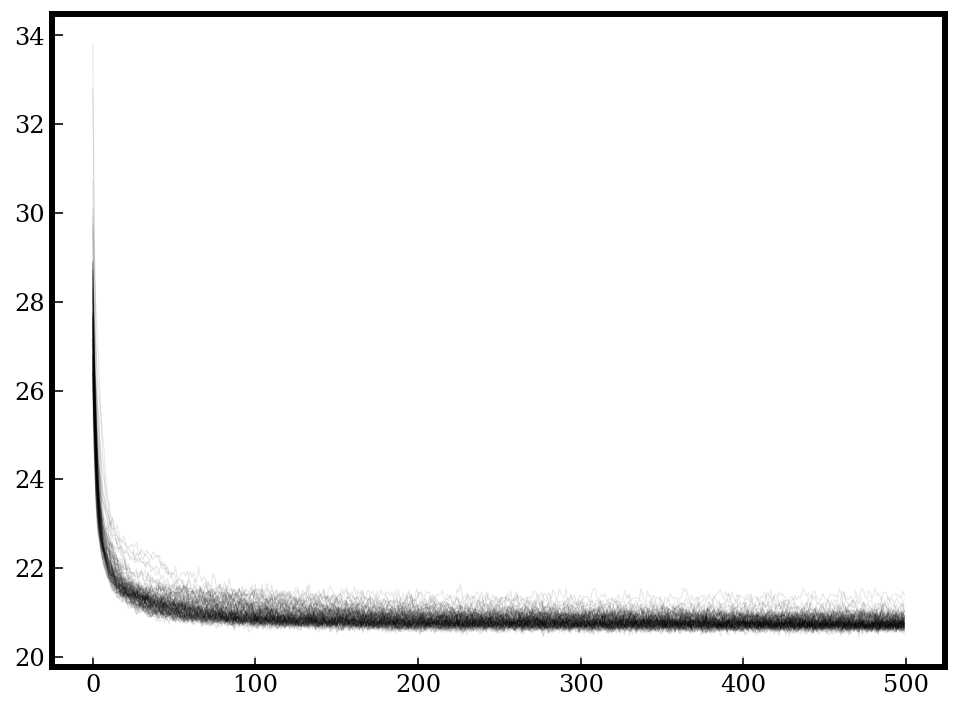

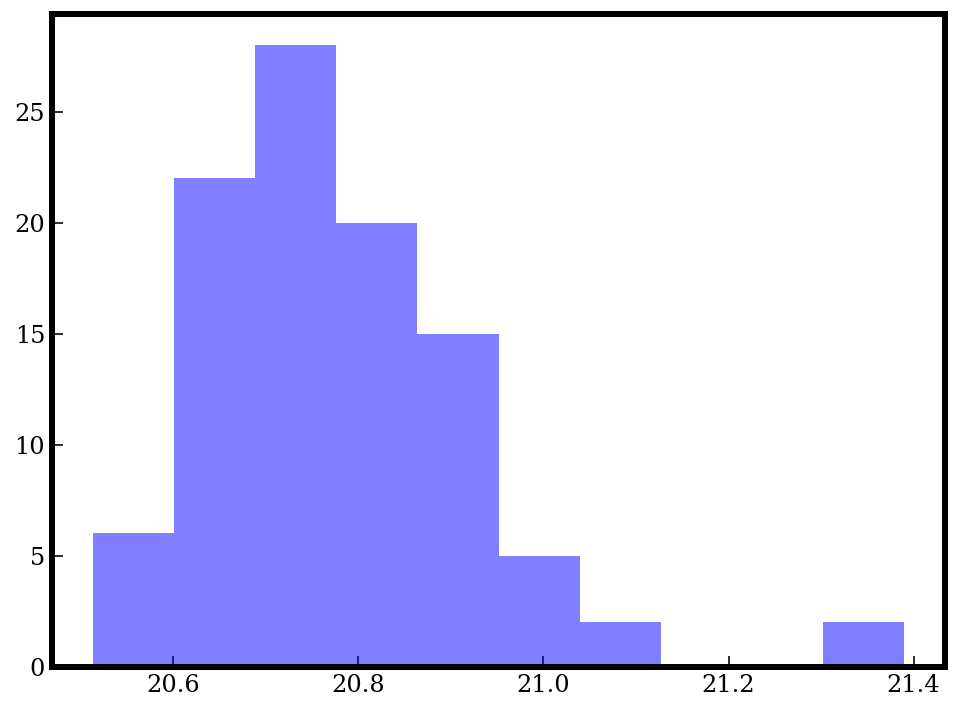

In [8]:
loss_arr = np.zeros((100))

fig1 = plt.figure(figsize=(8,6))

for j in range(0,len(loss_arr)):
    resultsFolder = "./realPlanets_incJ_final"
    loss_arr[j] = getLossFromLogfile("{0}/realKOIs_incJ_finalFeatures_seed={1}.log".format(resultsFolder,j))
    losses = getLossSeriesFromLogfile("{0}/realKOIs_incJ_finalFeatures_seed={1}.log".format(resultsFolder,j))
    plt.plot(np.arange(500),losses,'k-',lw=0.5,alpha=0.1)
plt.show()
    
fig = plt.figure(figsize=(8,6)) 
plt.hist(loss_arr,color='b',alpha=0.5)    
plt.show()


In [9]:
print(np.min(loss_arr))
print(np.argmin(loss_arr))

20.512946486473
41


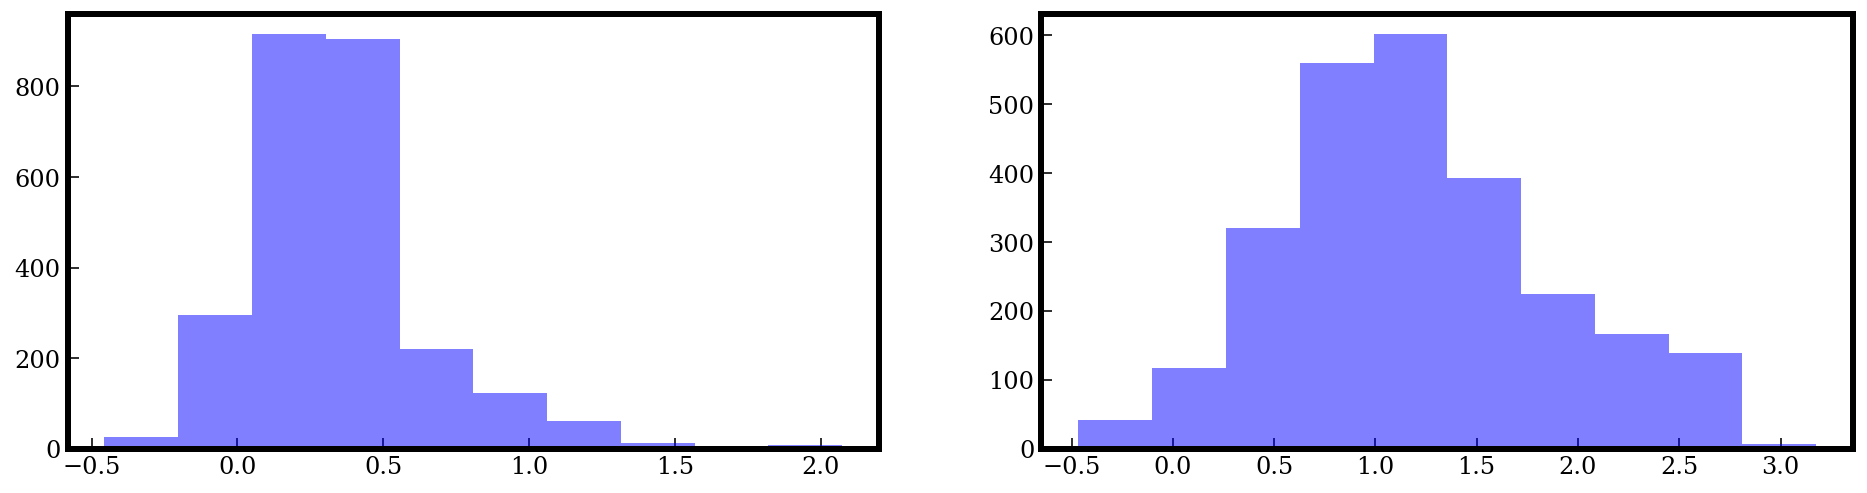

m is 1.0
(647,)
(647,)
m is 2.0
(274,)
(274,)
m is 3.0
(117,)
(117,)
m is 4.0
(56,)
(56,)
m is 5.0
(15,)
(15,)
m is 6.0
(6,)
(6,)
m is 7.0
(7,)
(7,)


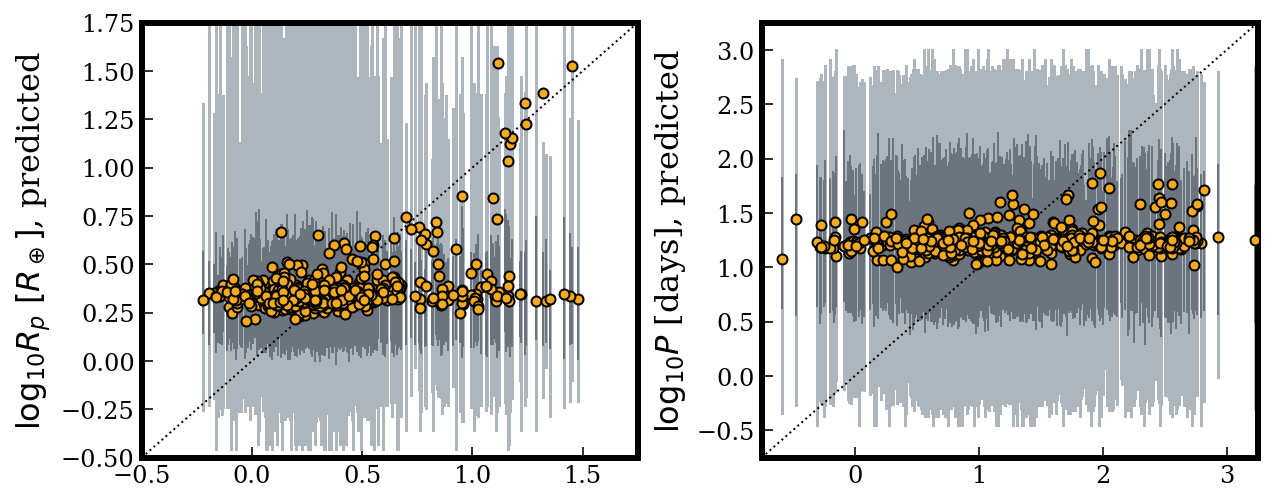

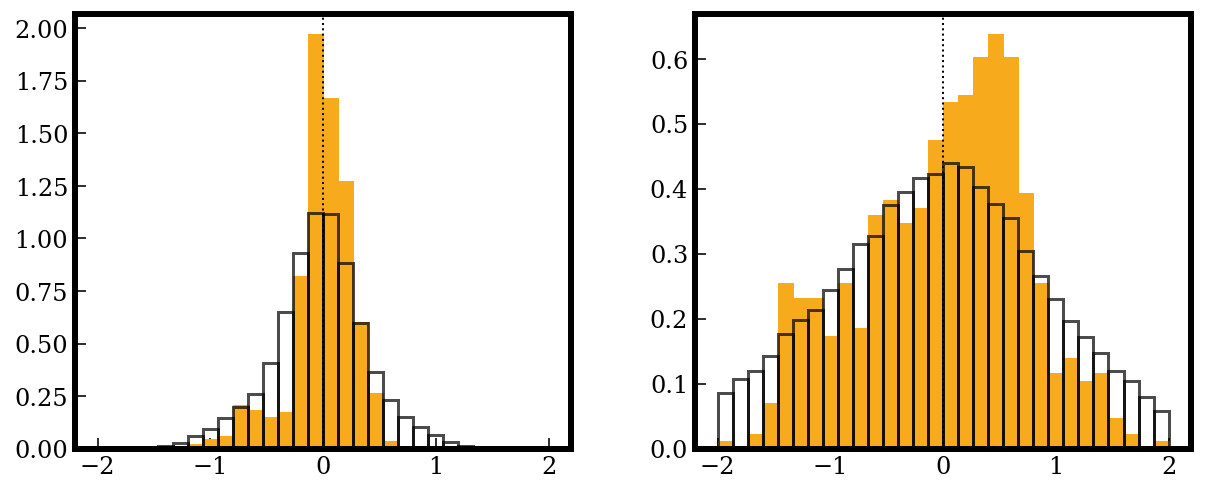

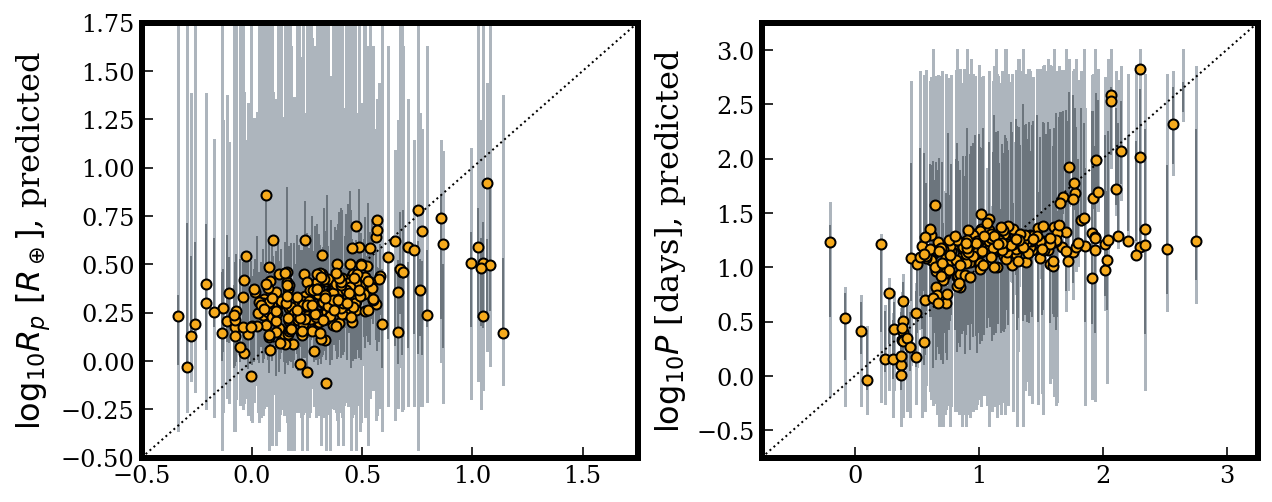

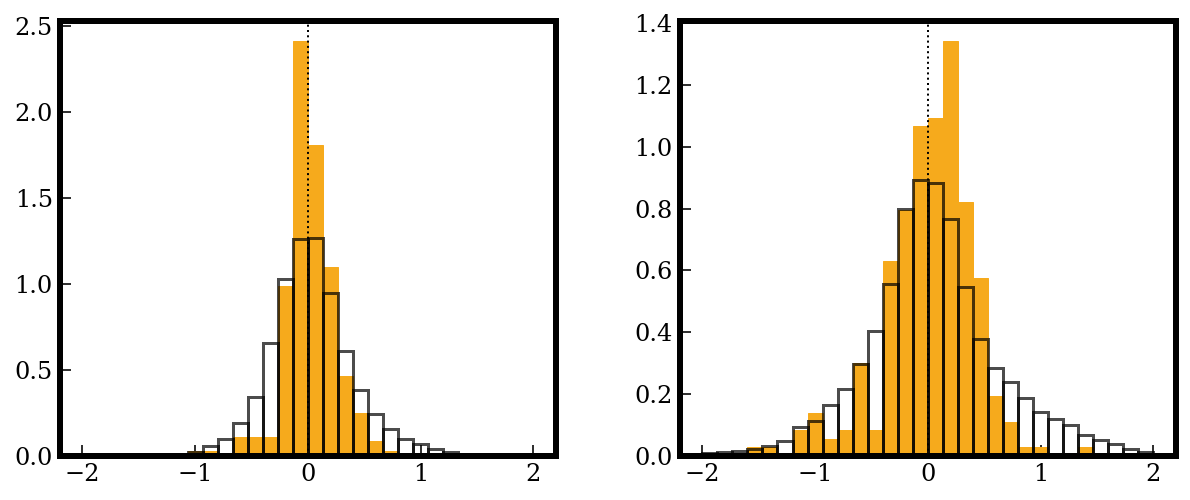

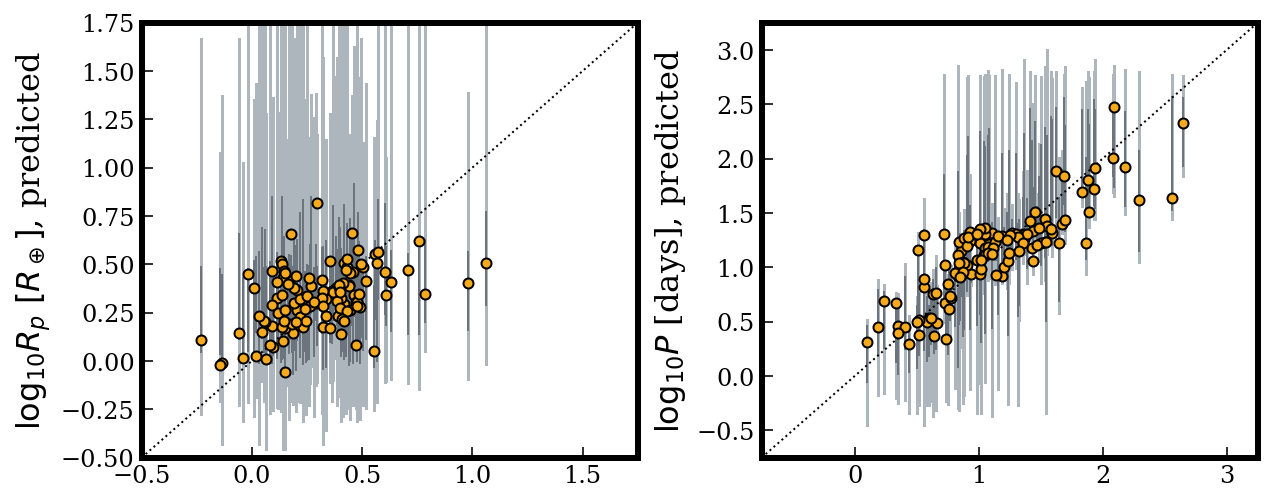

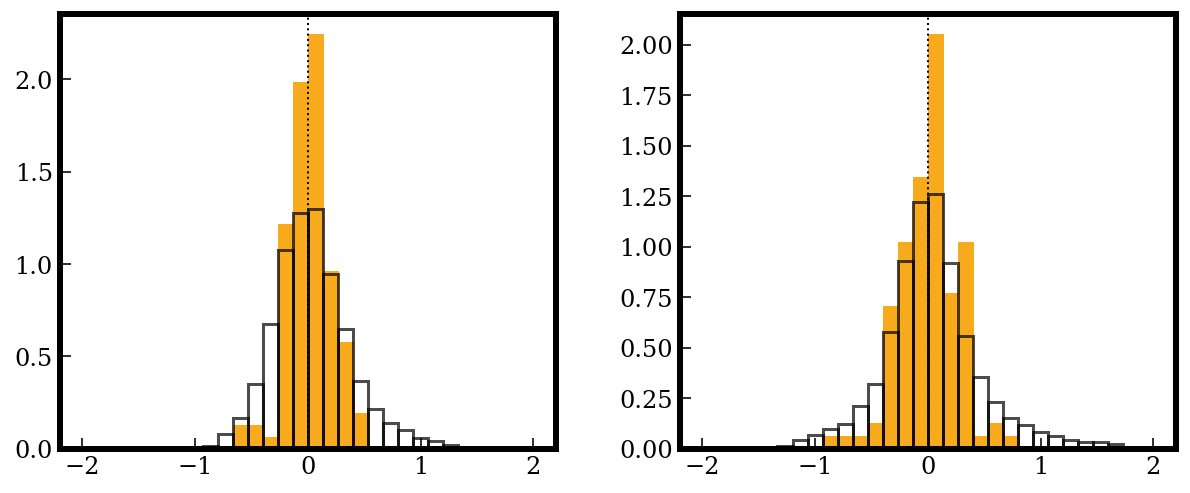

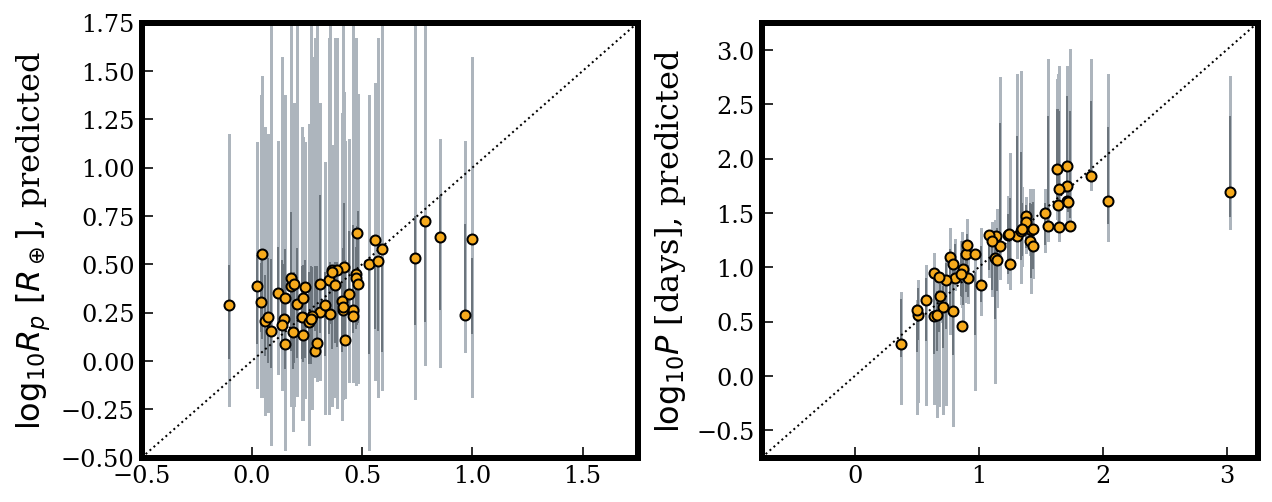

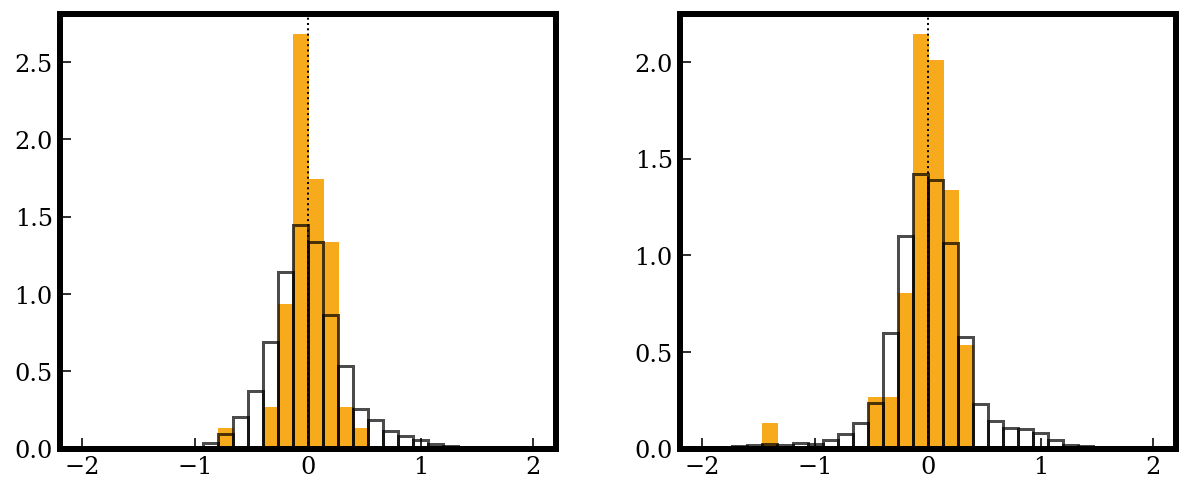

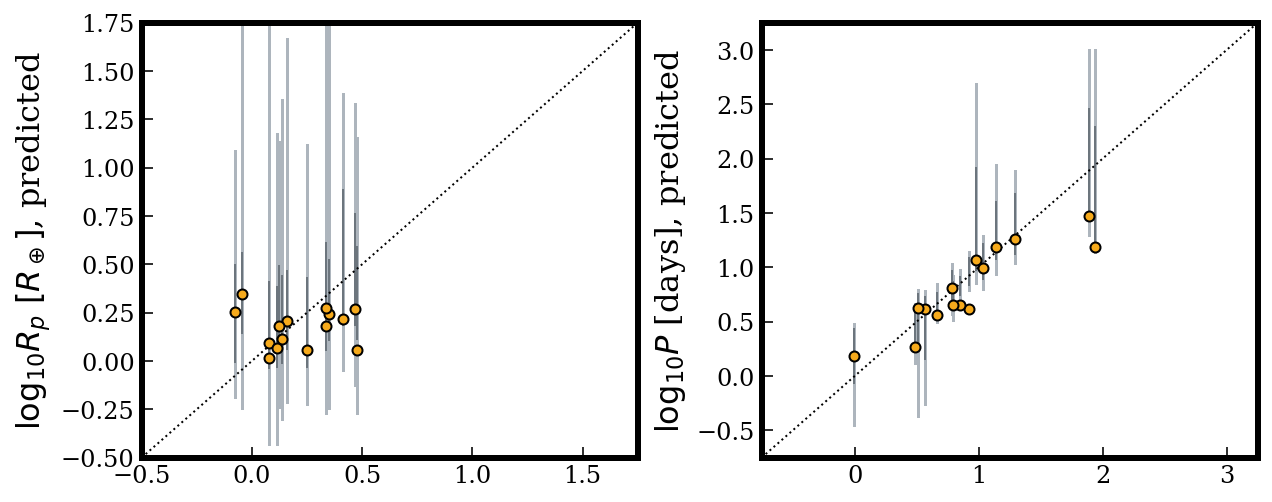

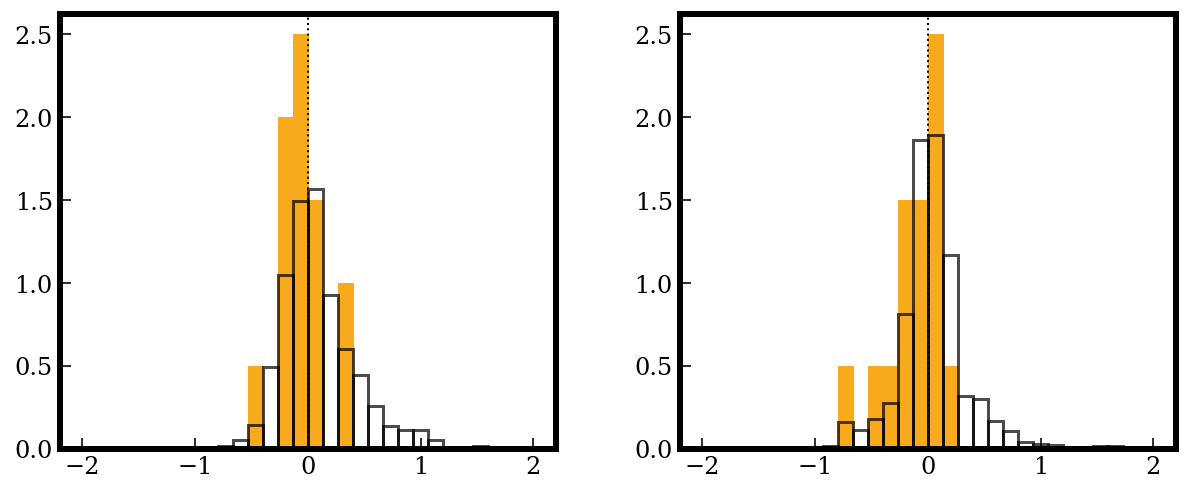

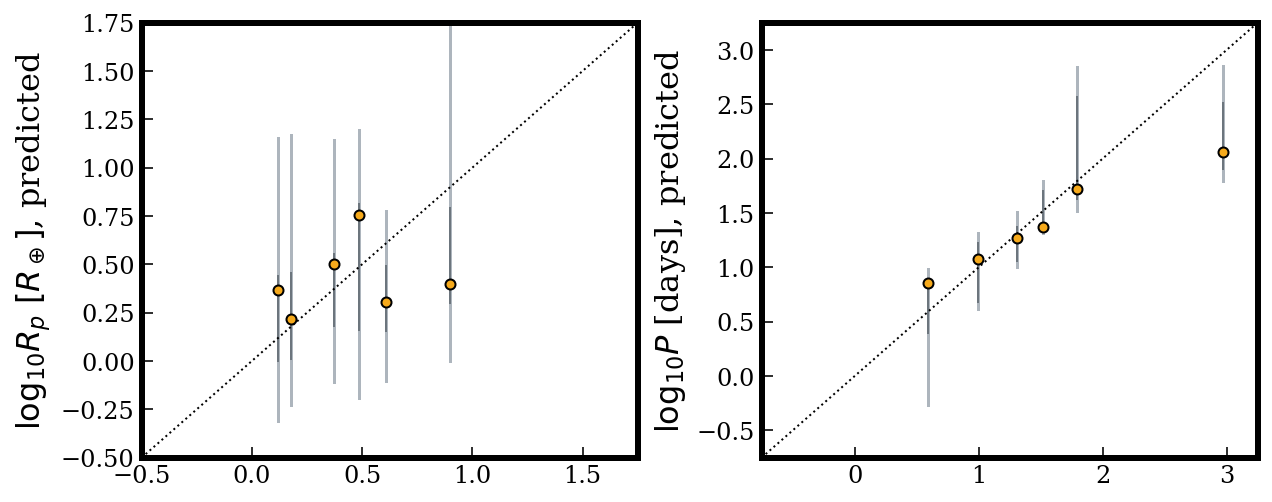

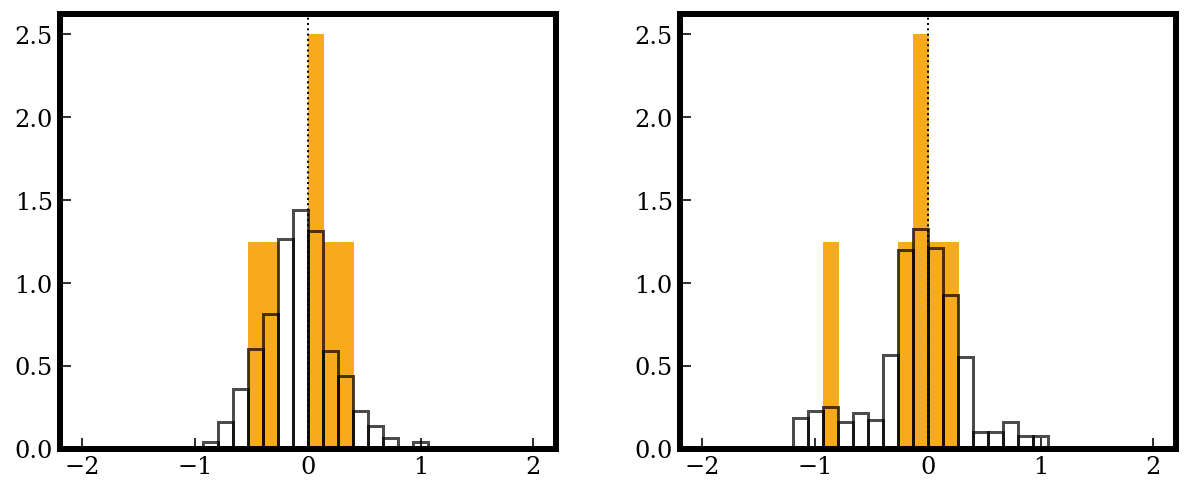

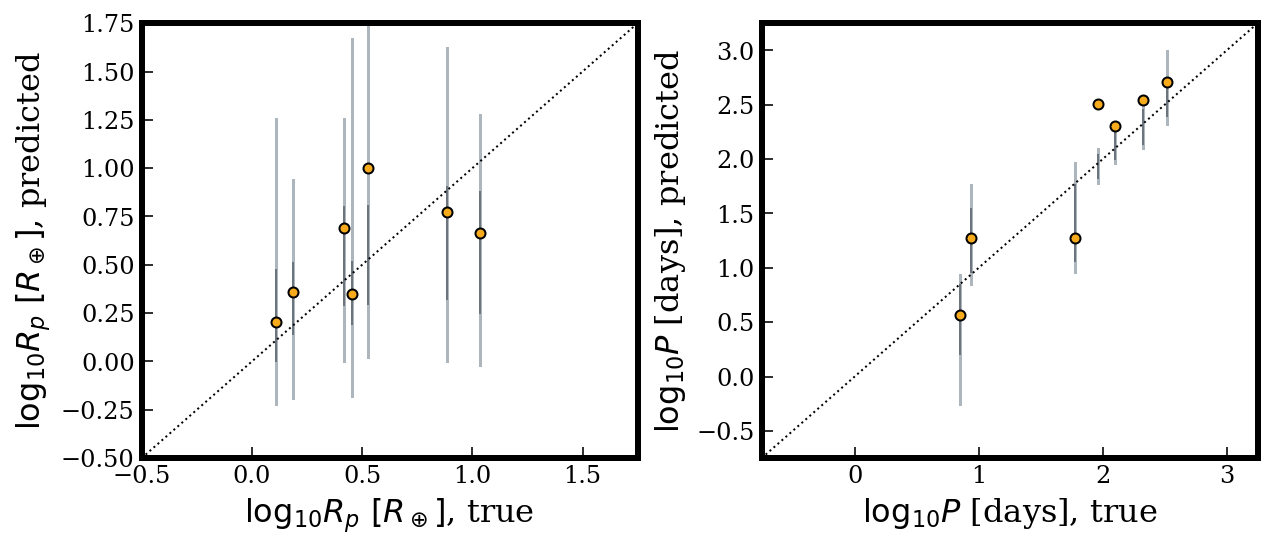

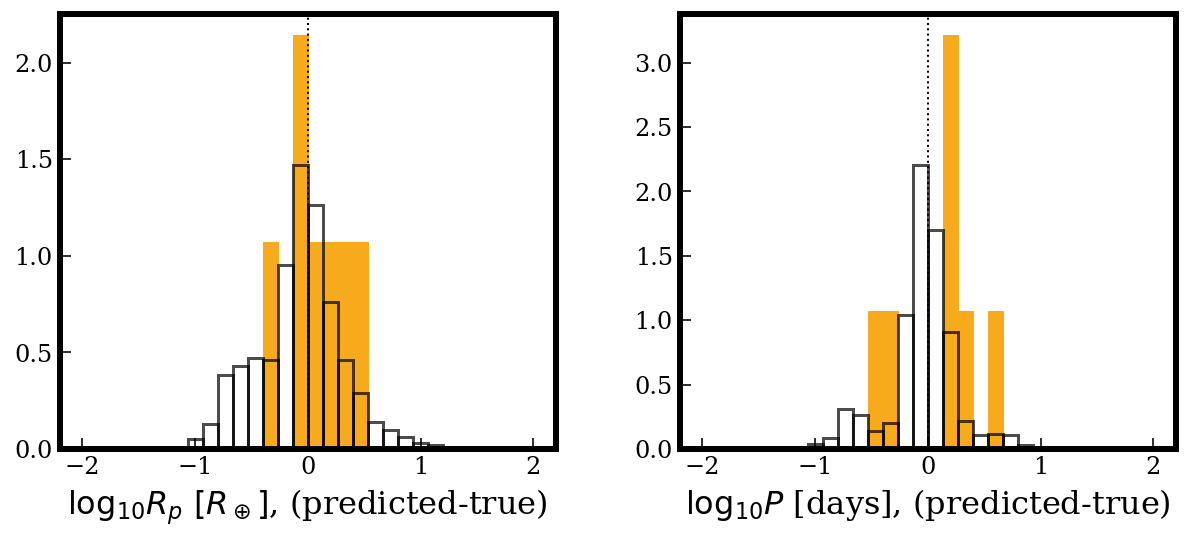

In [10]:
# optimal seed
seed = np.argmin(loss_arr)

maxmult = 7

predMSE = np.zeros((n_planet_features,maxmult))
randomMSE = np.zeros((n_planet_features,maxmult))

predMAE = np.zeros((n_planet_features,maxmult))
randomMAE = np.zeros((n_planet_features,maxmult))

predMAE_linear = np.zeros((n_planet_features,maxmult))
randomMAE_linear = np.zeros((n_planet_features,maxmult))

betterThan = np.zeros((n_planet_features,maxmult))
betterThanFrac = np.zeros((n_planet_features,maxmult))

nPlanets = np.zeros((n_planet_features,maxmult))
nPlanets_MSE = np.zeros((n_planet_features,maxmult))

resultsFolder = "./realPlanets_incJ_final"

logfile = "{0}/realKOIs_incJ_finalFeatures_seed={1}.log".format(resultsFolder,seed)

# get CV data
with open(CVDataFile, "rb") as picklefile:
    testSystems = pickle.load(picklefile)
    
# constraints colnames:
# kepid innerPlanetIdx outerPlanetIdx amin amax Pmin Pmax mmax Rpmax Rpmax_uerr Rpmax_lerr

CVdata = np.zeros((1,n_planet_features+1))
#CVconstraints = np.zeros((1,11))

for i in range(len(testSystems)):
    sys = testSystems[i]
    ID = sys[0]
    for j in range(1,len(sys)):
        row = np.zeros_like(CVdata[0])
        row[:-1] = np.array(sys[j])[0:n_planet_features]
        row[-1] = ID
        CVdata = np.vstack((CVdata,row))
    # organize constraints in the same order
    '''
    for j in range(1,len(sys)):
        c_row = np.zeros_like(CVconstraints[0])
        sys_constraints_mask = (constraints[:,0] == ID)
        sys_constraints_idxs = np.arange(len(constraints))[sys_constraints_mask]
        for c in sys_constraints_idxs:
            if constraints[c,1] == j-1:
                c_row[:] = constraints[c,3:]
                
        CVconstraints = np.vstack((CVconstraints,c_row))
    '''
CVdata = CVdata[1:]
#CVconstraints = CVconstraints[1:]

mults = np.zeros_like(CVdata[:,0])
for i in range(len(CVdata)):
    thisSystemMask = (CVdata[:,-1] == CVdata[i,-1])
    mults[i] = int(len(CVdata[thisSystemMask]))
    
CVdata = np.hstack((CVdata,np.atleast_2d(mults).T))
    
losses = np.load("{0}/realKOIs_finalFeatures_incJ_70percent_losses_{1}.npy".format(resultsFolder,seed))
CVresults = np.load("{0}/realKOIs_finalFeatures_incJ_30percent_truths_fromtarget_{1}.npy".format(resultsFolder,seed))
CVresults_fromContext = np.load("{0}/realKOIs_finalFeatures_incJ_30percent_predictions_fromcontext_{1}.npy".format(resultsFolder,seed))
CVidxs = np.load("{0}/realKOIs_finalFeatures_incJ_30percent_idxs_{1}.npy".format(resultsFolder,seed))

CVdata = CVdata[CVidxs]
#CVconstraints = CVconstraints[CVidxs]
    
    
# get training data
trainingIdxs = np.load("{0}/realKOIs_finalFeatures_incJ_70percent_idxs_{1}.npy".format(resultsFolder,seed))

with open(trainingDataFile,"rb") as picklefile:
    trainingSystems = pickle.load(picklefile)

trainingData = np.zeros((1,n_planet_features))

for i in range(len(trainingSystems)):
    sys = trainingSystems[i]
    for j in range(1,len(sys)):
        trainingData = np.vstack((trainingData,np.array(sys[j])[0:n_planet_features]))

trainingData = trainingData[1:][trainingIdxs]
    
fig, axes = plt.subplots(1,n_planet_features,figsize=(16,4))
for i in range(n_planet_features):
    axes[i].hist((trainingData[:,i]*sigmas[i])+mus[i],color='b',alpha=0.5)
plt.show()
    
trainingResults = np.load("./{0}/realKOIs_finalFeatures_incJ_70percent_truths_fromtarget_{1}.npy".format(resultsFolder,seed))



# naive predictions
randomPredictions = randomStablePlanet(testSetSystems=testSystems, 
                                        testSetResults=CVresults_fromContext,
                                        trainingSetResults=trainingResults, 
                                        trainingSetData=trainingData, 
                                        nSamples=n_samples)
        
randomPredictions = randomPredictions[CVidxs]

# plot training-based predictions
#markers=['.','v','X','1','s','x','^','2','D','o']
markers=['.']
    
# constraints colnames:
# kepid innerPlanetIdx outerPlanetIdx amin amax Pmin Pmax mmax Rpmax Rpmax_uerr Rpmax_lerr rormax rormax_uerr rormax_lerr
    
for m in np.sort(np.unique(mults)):
    print("m is {0}".format(m))
    fig,axes = plt.subplots(1,n_planet_features,figsize = (n_planet_features*5,4))
    '''
    #Rp/R*
    xs = ((CVdata[:,0]*sigmas[0])+mus[0])[CVdata[:,-1] == m]
    cs = CVconstraints[CVdata[:,-1] == m]
        
    for cc in range(len(cs)):
        #print(xs[cc])
        #print(cs[cc])
        if cs[cc,0] > 0.:
            axes[0].plot(xs[cc],np.log10(cs[cc,8]),color='b',marker='v',alpha=0.5)
            axes[0].plot(xs[cc]*np.ones((2)),np.log10(np.array((cs[cc,8]-cs[cc,10],cs[cc,8]+cs[cc,9]))),color='b',marker='None',lw=0.5,alpha=0.5)
    
    # period
    xs = ((CVdata[:,1]*sigmas[1])+mus[1])[CVdata[:,-1] == m]
    cs = CVconstraints[CVdata[:,-1] == m]
        
    for cc in range(len(cs)):
        if cs[cc,0] > 0.:
            axes[1].plot(xs[cc]*np.ones((2)),np.log10(cs[cc,2:4]),color='b',marker='None',lw=0.5,alpha=0.5)
    '''        
    for i in range(n_planet_features):    
        axes[i].plot(((CVdata[:,i]*sigmas[i])+mus[i])[CVdata[:,-1] == m],
                     ((CVresults_fromContext[:,i]*sigmas[i])+mus[i])[CVdata[:,-1] == m],
                     color='#F6AA1C',marker='.',ms=10,mec="k",ls="None",alpha=1,zorder=3)
        
        for p_i in range(len(CVdata[CVdata[:,-1] == m])):
            randomMin = np.min(((randomPredictions[:,:,i]*sigmas[i])+mus[i])[CVdata[:,-1] == m][p_i])
            randomMax = np.max(((randomPredictions[:,:,i]*sigmas[i])+mus[i])[CVdata[:,-1] == m][p_i])
                
            random16 = np.percentile(((randomPredictions[:,:,i]*sigmas[i])+mus[i])[CVdata[:,-1] == m][p_i],16)
            random50 = np.percentile(((randomPredictions[:,:,i]*sigmas[i])+mus[i])[CVdata[:,-1] == m][p_i],16)
            random84 = np.percentile(((randomPredictions[:,:,i]*sigmas[i])+mus[i])[CVdata[:,-1] == m][p_i],84)
                
            axes[i].plot(((CVdata[:,i]*sigmas[i])+mus[i])[CVdata[:,-1] == m][p_i] * np.ones((2)),
                             np.array((randomMin,randomMax)),
                             marker='None',ls='-',lw=1.5,color='#adb5bd',zorder=1)
            axes[i].plot(((CVdata[:,i]*sigmas[i])+mus[i])[CVdata[:,-1] == m][p_i] * np.ones((2)),
                             np.array((random16,random84)),
                             marker='None',ls='-',lw=1,color='#6c757d',zorder=2)
        
        if m==7:
            axes[i].set_xlabel("{0}, true".format(labels[i]),fontsize=16)
        axes[i].set_ylabel("{0}, predicted".format(labels[i]),fontsize=16)
        axes[i].set_xlim(scatterlims[i])
        axes[i].set_ylim(scatterlims[i])

        x_ = np.linspace(scatterlims[i][0],scatterlims[i][1],2)
        axes[i].plot(x_,x_,'k:',lw=1)
        #axes[i].legend(loc='best',frameon='False')
    plt.subplots_adjust(wspace=0.5)
    #axes[0].set_title("m = {0}".format(int(m)),fontsize=18)
    plt.subplots_adjust(wspace=0.25)
    plt.savefig("./{0}/realKOIs_finalFeatures_incJ_30percent_CV_stablePredictions_{1}_mult={2}.pdf".format(resultsFolder,seed,m),fmt="pdf",bbox_inches="tight")
    #plt.close()
    
    
    
    # histograms of (X_predicted - X_true)/X_true
    fig,axes = plt.subplots(1,n_planet_features,figsize = (n_planet_features*5,4))

    for i in range(n_planet_features):
        phys_truth = ((CVdata[:,i]*sigmas[i])+mus[i])[CVdata[:,-1] == m]

        phys_pred = ((CVresults_fromContext[:,i]*sigmas[i])+mus[i])[CVdata[:,-1] == m]
        
        
        err_pred = (phys_pred - phys_truth)#/phys_truth
        err_pred_linear = (10**phys_pred - 10**phys_truth)
        
        err_random = np.zeros_like(phys_truth)
        err_random_linear = np.zeros_like(phys_truth)
        
        err_random_50 = np.zeros_like(phys_truth)
        phys_random_50 = np.percentile(((randomPredictions[:,:,i]*sigmas[i])+mus[i])[CVdata[:,-1] == m],50,axis=1)
        err_random_50 = phys_random_50 - phys_truth
        print(np.shape(err_random_50))
        
        for j in range(n_samples):
            phys_random = ((randomPredictions[:,j,i]*sigmas[i])+mus[i])[CVdata[:,-1] == m]
            err_random_j = (phys_random - phys_truth)#/phys_truth
            
            err_random_linear_j = (10**phys_random - 10**phys_truth)
            err_random = np.vstack((err_random,err_random_j))
            err_random_linear = np.vstack((err_random_linear, err_random_linear_j))
            
        err_random = err_random[1:]
        err_random = np.ravel(err_random)
        err_random = err_random
        
    
        
        err_random_linear = err_random_linear[1:]
        err_random_linear = np.ravel(err_random_linear)
        err_random_linear = err_random_linear
        
        MSE_pred = (1/len(err_pred[np.isfinite(err_pred)]))*np.sum(err_pred[np.isfinite(err_pred)]**2)
        MSE_random = (1/len(err_random[np.isfinite(err_random)]))*np.sum(err_random[np.isfinite(err_random)]**2)
        
        MAE_pred = (1/len(err_pred[np.isfinite(err_pred)]))*np.sum(np.abs(err_pred[np.isfinite(err_pred)]))
        MAE_random = (1/len(err_random[np.isfinite(err_random)]))*np.sum(np.abs(err_random[np.isfinite(err_random)]))
        
        MAE_pred_linear = (1/len(err_pred[np.isfinite(err_pred_linear)]))*np.sum(np.abs(err_pred_linear[np.isfinite(err_pred_linear)]))
        MAE_random_linear = (1/len(err_random_linear[np.isfinite(err_random_linear)]))*np.sum(np.abs(err_random_linear[np.isfinite(err_random_linear)]))
        
        
        skew_pred = skew(err_pred)
        skew_random = skew(err_random)
        
        betterThanMask = (err_pred < err_random_50)
        betterThanFrac[int(i),int(m)-1] = len(phys_truth[betterThanMask])/len(phys_truth)
        betterThan[int(i),int(m)-1] = len(phys_truth[betterThanMask])
        
        nPlanets[int(i),int(m)-1] = len(phys_truth)
        nPlanets_MSE[int(i),int(m)-1] = len(err_pred[np.isfinite(err_pred)])
        predMSE[int(i),int(m)-1] = MSE_pred
        randomMSE[int(i),int(m)-1] = MSE_random
        predMAE[int(i),int(m)-1] = MAE_pred
        randomMAE[int(i),int(m)-1] = MAE_random
        
        predMAE_linear[int(i),int(m)-1] = MAE_pred_linear
        randomMAE_linear[int(i),int(m)-1] = MAE_random_linear

        axes[i].hist(err_pred,density=True,range=lims[i],bins=30,facecolor="#F6AA1C",edgecolor="#F6AA1C",alpha=1,label="network-predicted\nMSE={0:.1e},\nskewness={1:.1f}".format(MSE_pred,skew_pred),zorder=1)

        #axes[i].hist(err_random_50,density=True,range=lims[i],bins=30,facecolor="k",edgecolor="k",alpha=1,label="network-predicted\nMSE={0:.1e},\nskewness={1:.1f}".format(MSE_pred,skew_pred),zorder=2)
        axes[i].hist(err_random,density=True,range=lims[i],bins=30,facecolor="None",edgecolor="k",lw=1.5,alpha=0.7,label="random\nMSE={0:.1e},\nskewness={1:.1f}".format(MSE_random,skew_random),zorder=3)    
        
        axes[i].axvline(x=0,color='k',ls=':',lw=1)
        if m==7:
            axes[i].set_xlabel("{0}, (predicted-true)".format(labels[i]),fontsize=16)

        #axes[i].set_ylabel("count".format(labels[i]),fontsize=16)
        #axes[i].legend(loc="upper right",frameon=False)
    #axes[0].set_ylabel("m = {0}".format(int(m)),fontsize=18)
    plt.subplots_adjust(wspace=0.25)
    #plt.show()
    plt.savefig("./{0}/realKOIs_finalFeatures_incJ_30percent_CV_stablePredictions_hist_{1}_mult={2}.pdf".format(resultsFolder,seed,m),fmt="pdf",bbox_inches="tight")
    #plt.close()

        

In [11]:
print(np.shape(predMSE))
print(np.shape(np.sum(predMSE,axis=0)))
print(nPlanets_MSE)
print(nPlanets)
print(betterThanFrac)
print(np.mean(betterThanFrac[:,1:],axis=1))
print(betterThan)

(2, 7)
(7,)
[[647. 274. 117.  56.  15.   6.   7.]
 [647. 274. 117.  56.  15.   6.   7.]]
[[647. 274. 117.  56.  15.   6.   7.]
 [647. 274. 117.  56.  15.   6.   7.]]
[[0.33693972 0.45620438 0.41880342 0.35714286 0.93333333 0.33333333
  0.14285714]
 [0.13292117 0.55109489 0.5042735  0.5        0.86666667 0.5
  0.28571429]]
[0.44027908 0.53462489]
[[218. 125.  49.  20.  14.   2.   1.]
 [ 86. 151.  59.  28.  13.   3.   2.]]


[0.08316691 0.04905501 0.03911551 0.0390649  0.04012654 0.0821138
 0.07122631]


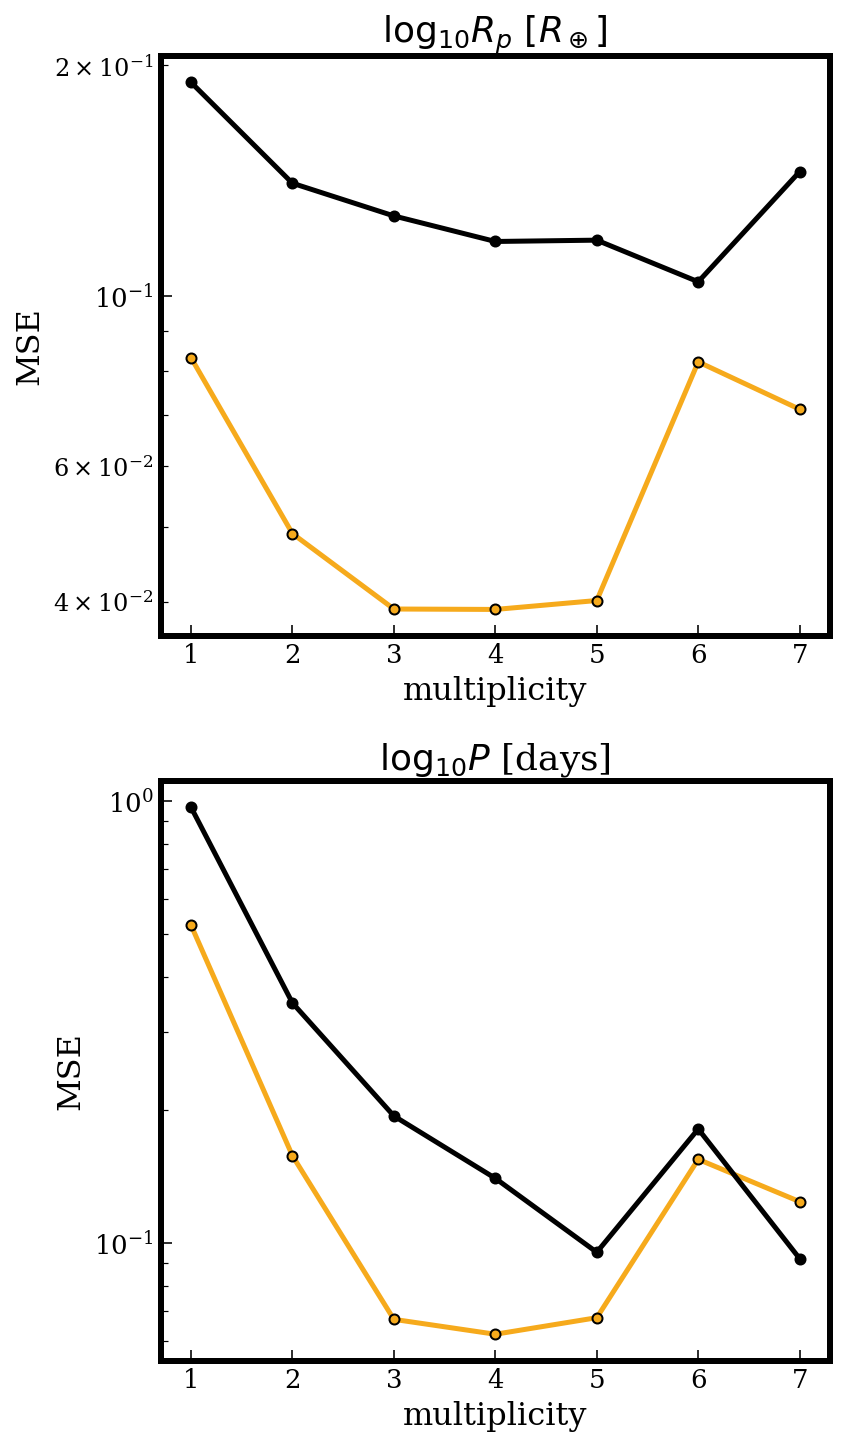

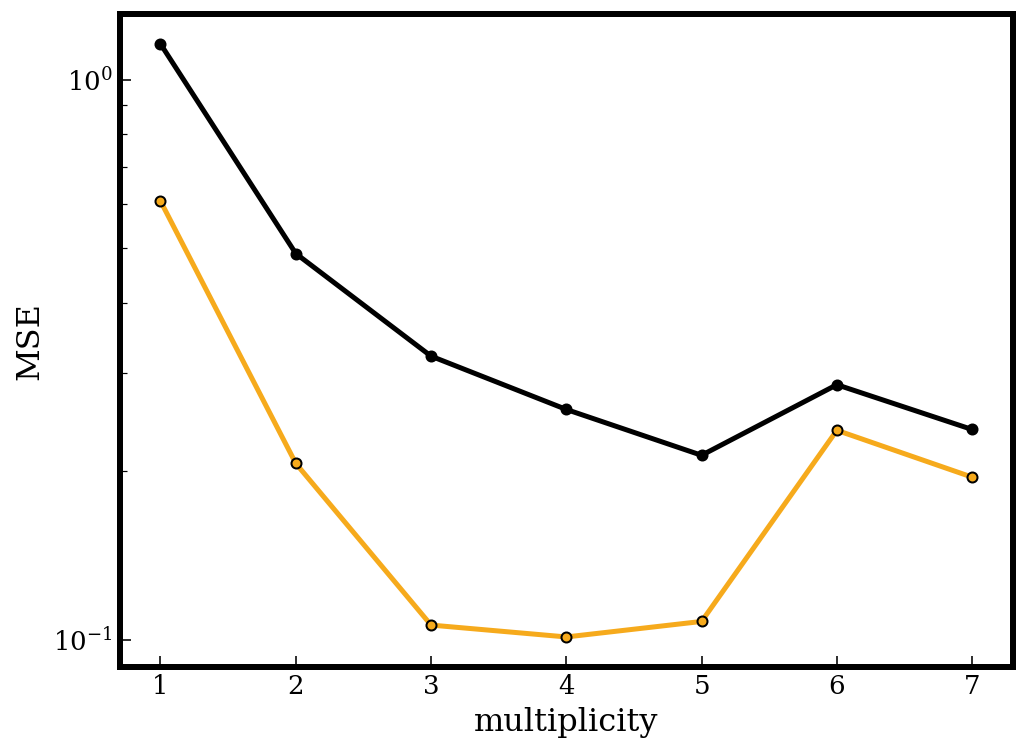

In [12]:
markers=['.','v','X','1','s','x','^','2','D','o']
fig,axes = plt.subplots(n_planet_features,1,figsize=(6,6*n_planet_features))
for j in range(n_planet_features):
    axes[j].plot(np.arange(1,maxmult+1),predMSE[j],color='#F6AA1C',marker='.',mec='k',ms=10)
    axes[j].plot(np.arange(1,maxmult+1),randomMSE[j],color='k',marker='.',mec='k',ms=10)
    axes[j].set_xlabel("multiplicity",fontsize=16)
    axes[j].set_ylabel("MSE",fontsize=16)
    axes[j].set_yscale("log")
    axes[j].set_title("{0}".format(labels[j]),fontsize=18)
    for tick in axes[j].xaxis.get_major_ticks():
        tick.label.set_fontsize(13)
    for tick in axes[j].yaxis.get_major_ticks():
        tick.label.set_fontsize(13)
#plt.show()
plt.subplots_adjust(hspace=0.25)
plt.savefig("./{0}/realKOIs_finalFeatures_incJ_30percent_CV_MSEcomparison_{1}.pdf".format(resultsFolder,seed),fmt="pdf",bbox_inches='tight')

goodresults = np.arange((6))

fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(np.arange(1,maxmult+1),np.sum(predMSE,axis=0),color='#F6AA1C',marker='.',mec='k',ms=10,label="network-trained predictions")
ax.plot(np.arange(1,maxmult+1),np.sum(randomMSE,axis=0),color='k',marker='.',mec='k',ms=10,label="naive predictions")
ax.set_xlabel("multiplicity",fontsize=16)
ax.set_ylabel("MSE",fontsize=16)
#plt.legend(loc="best")
ax.set_yscale("log")

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(13)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(13)

#plt.show()
plt.savefig("./{0}/realKOIs_finalFeatures_incJ_30percent_CV_MSEsumcomparison_{1}.pdf".format(resultsFolder,seed),fmt="pdf",bbox_inches='tight')

print(predMSE[0])


[0.08316691 0.04905501 0.03911551 0.0390649  0.04012654 0.0821138
 0.07122631]


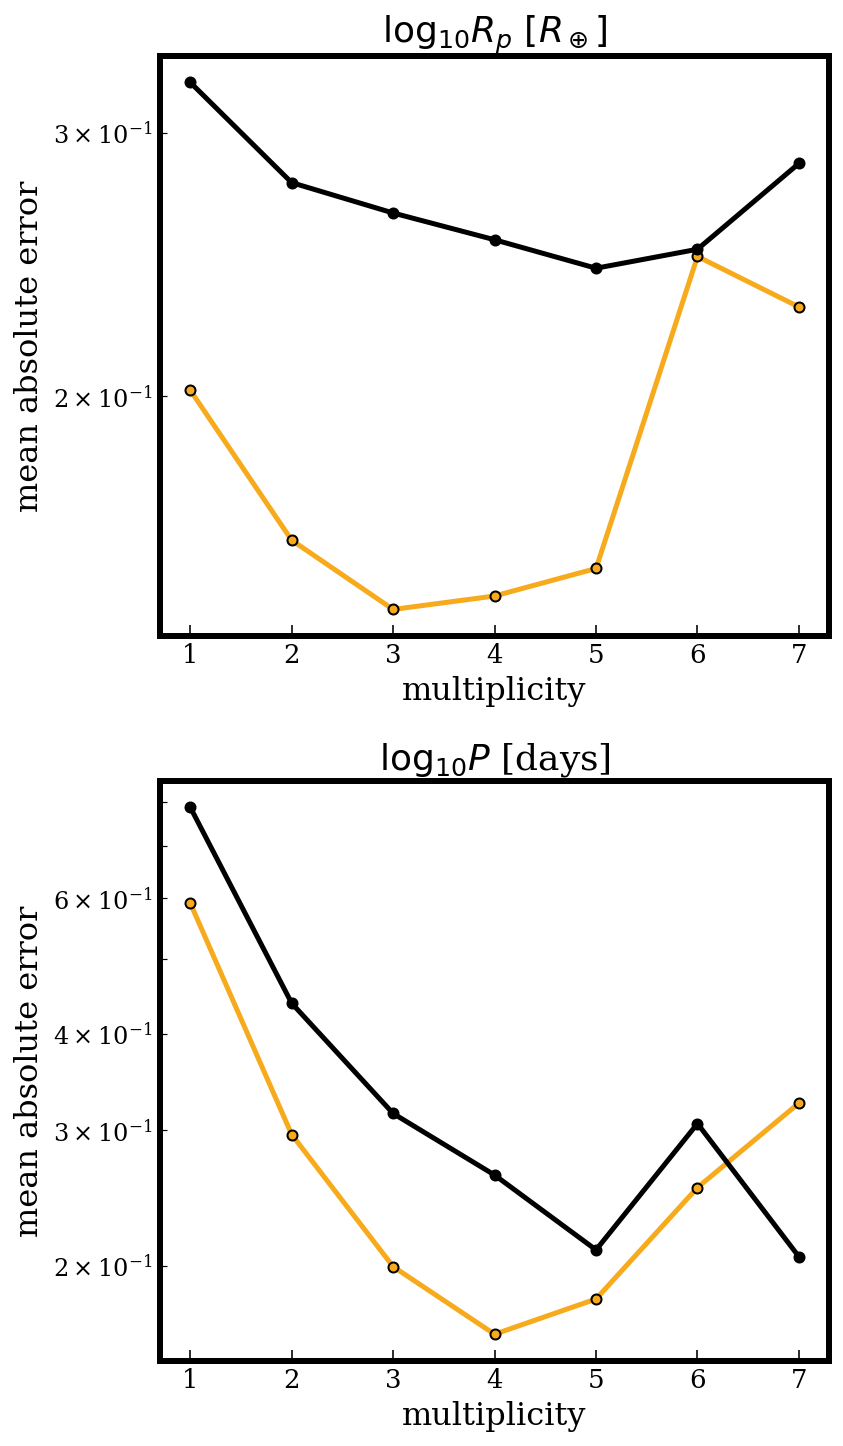

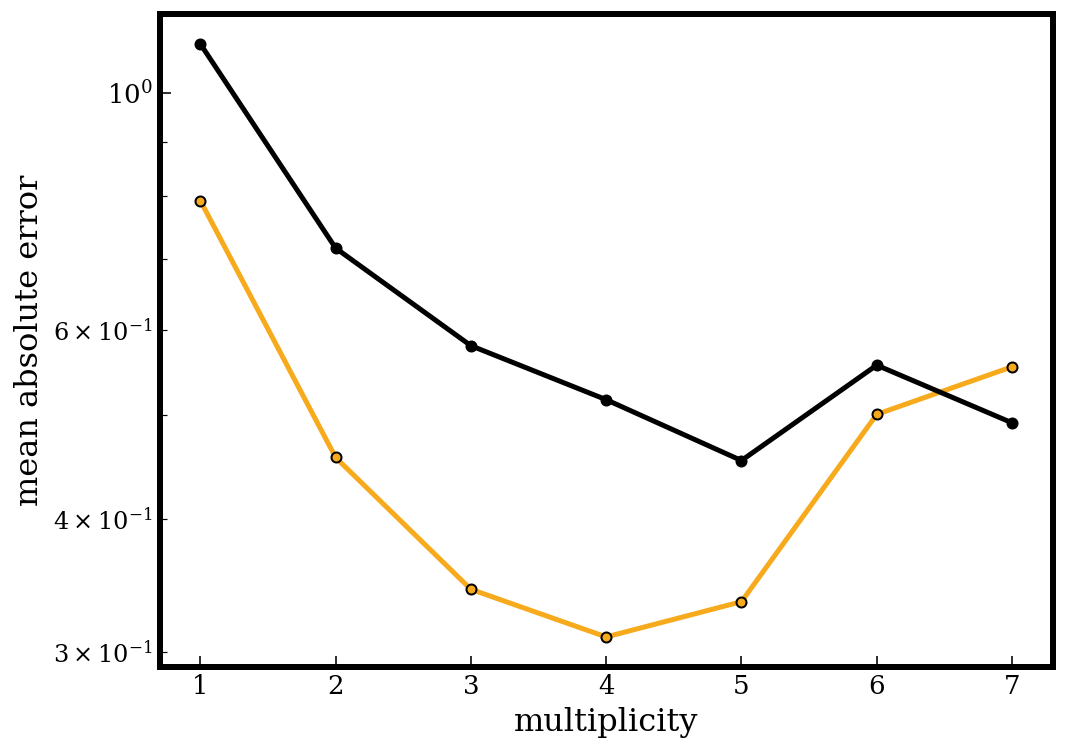

In [13]:
markers=['.','v','X','1','s','x','^','2','D','o']
fig,axes = plt.subplots(n_planet_features,1,figsize=(6,6*n_planet_features))
for j in range(n_planet_features):
    axes[j].plot(np.arange(1,maxmult+1),predMAE[j],color='#F6AA1C',marker='.',mec='k',ms=10)
    axes[j].plot(np.arange(1,maxmult+1),randomMAE[j],color='k',marker='.',mec='k',ms=10)
    axes[j].set_xlabel("multiplicity",fontsize=16)
    axes[j].set_ylabel("mean absolute error",fontsize=16)
    axes[j].set_yscale("log")
    axes[j].set_title("{0}".format(labels[j]),fontsize=18)
    for tick in axes[j].xaxis.get_major_ticks():
        tick.label.set_fontsize(13)
    for tick in axes[j].yaxis.get_major_ticks():
        tick.label.set_fontsize(13)
#plt.show()
plt.subplots_adjust(hspace=0.25)
plt.savefig("./{0}/realKOIs_finalFeatures_incJ_30percent_CV_MAEcomparison_{1}.pdf".format(resultsFolder,seed),fmt="pdf",bbox_inches='tight')

goodresults = np.arange((6))

fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(np.arange(1,maxmult+1),np.sum(predMAE,axis=0),color='#F6AA1C',marker='.',mec='k',ms=10,label="network-trained predictions")
ax.plot(np.arange(1,maxmult+1),np.sum(randomMAE,axis=0),color='k',marker='.',mec='k',ms=10,label="naive predictions")
ax.set_xlabel("multiplicity",fontsize=16)
ax.set_ylabel("mean absolute error",fontsize=16)
#plt.legend(loc="best")
ax.set_yscale("log")

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(13)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(13)

#plt.show()
plt.savefig("./{0}/realKOIs_finalFeatures_incJ_30percent_CV_MAEsumcomparison_{1}.pdf".format(resultsFolder,seed),fmt="pdf",bbox_inches='tight')

print(predMSE[0])


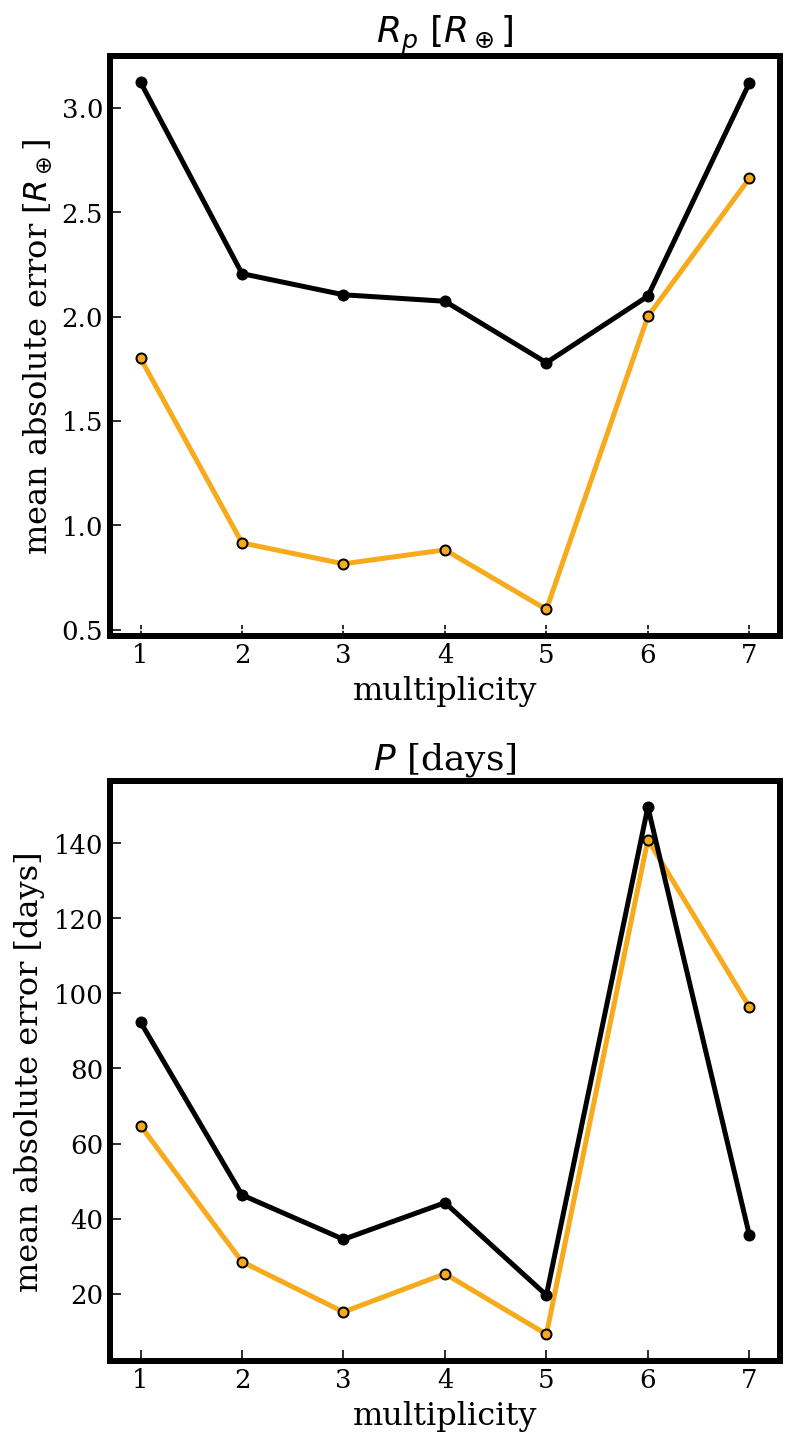

In [14]:
linear_labels = [r'$R_p\ [R_\oplus]$',r'$P$ [days]',r'$T_{eff}$ [K]',r'$\log{g}\ [\mathrm{cm}/\mathrm{s}^2]$']
units = ['$R_\oplus$',r'days']
markers=['.','v','X','1','s','x','^','2','D','o']
fig,axes = plt.subplots(n_planet_features,1,figsize=(6,6*n_planet_features))
for j in range(n_planet_features):
    axes[j].plot(np.arange(1,maxmult+1),predMAE_linear[j],color='#F6AA1C',marker='.',mec='k',ms=10)
    axes[j].plot(np.arange(1,maxmult+1),randomMAE_linear[j],color='k',marker='.',mec='k',ms=10)
    axes[j].set_xlabel("multiplicity",fontsize=16)
    axes[j].set_ylabel("mean absolute error [{0}]".format(units[j]),fontsize=16)
    #axes[j].set_yscale("log")
    axes[j].set_title("{0}".format(linear_labels[j]),fontsize=18)
    for tick in axes[j].xaxis.get_major_ticks():
        tick.label.set_fontsize(13)
    for tick in axes[j].yaxis.get_major_ticks():
        tick.label.set_fontsize(13)
#plt.show()
plt.subplots_adjust(hspace=0.25)
plt.savefig("./{0}/realKOIs_finalFeatures_incJ_30percent_CV_MAEcomparison_linear_{1}.pdf".format(resultsFolder,seed),fmt="pdf",bbox_inches='tight')




In [15]:
print(np.shape(predMSE)[0])

2


In [16]:
# how much better did we do? MSE
print(np.mean(randomMSE[0]/predMSE[0])) #radius
print(np.mean(randomMSE[1]/predMSE[1])) #period

print(np.average(randomMSE[0]/predMSE[0],weights=nPlanets_MSE[0])) #radius
print(np.average(randomMSE[1]/predMSE[1],weights=nPlanets_MSE[1])) #period

print(np.average(randomMSE[0,1:]/predMSE[0,1:],weights=nPlanets_MSE[0,1:])) #radius
print(np.average(randomMSE[1,1:]/predMSE[1,1:],weights=nPlanets_MSE[1,1:])) #period

2.5252416485069706
1.7899880909902564
2.5649441813486065
2.0511470488627315
2.9467760632586435
2.3266762610431257


In [17]:
# how much better did we do? mean absolute error
print(np.mean(randomMAE[0]/predMAE[0])) #radius
print(np.mean(randomMAE[1]/predMAE[1])) #period

print(np.average(randomMAE[0]/predMAE[0],weights=nPlanets_MSE[0])) #radius
print(np.average(randomMAE[1]/predMAE[1],weights=nPlanets_MSE[1])) #period

print(np.average(randomMAE[0,1:]/predMAE[0,1:],weights=nPlanets_MSE[0,1:])) #radius
print(np.average(randomMAE[1,1:]/predMAE[1,1:],weights=nPlanets_MSE[1,1:])) #period

1.5367260936786253
1.2857868266228436
1.6623106260169713
1.4001329421512214
1.7388707915179165
1.4938092280271542


In [18]:
# how much better did we do? mean absolute error
print(np.mean(randomMAE_linear[0]/predMAE_linear[0])) #radius
print(np.mean(randomMAE_linear[1]/predMAE_linear[1])) #period

print(np.average(randomMAE_linear[0]/predMAE_linear[0],weights=nPlanets_MSE[0])) #radius
print(np.average(randomMAE_linear[1]/predMAE_linear[1],weights=nPlanets_MSE[1])) #period

print(np.average(randomMAE_linear[0,1:]/predMAE_linear[0,1:],weights=nPlanets_MSE[0,1:])) #radius
print(np.average(randomMAE_linear[1,1:]/predMAE_linear[1,1:],weights=nPlanets_MSE[1,1:])) #period

2.0385389949208608
1.518453851611929
2.0274539971457624
1.5791055567466574
2.425815726228871
1.788733819522088
